In [86]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

import csv
from datetime import datetime
from datetime import timedelta
#from struct import pack
import os
import gc
from numpy import abs, max 
import scipy
#from scipy import io
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import butter, lfilter
from scipy import signal
#from scipy.signal import blackman
#from scipy.signal import periodogram
#import gc
#import os
import sys
import pandas as pd
#from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.spatial import distance

gc.enable()

video_start = '20190501'#'20190327'#'20181220' #YYYYMMDD
video_end = '20190501'#'20190327'#'20181220' #YYYYMMDD
data_path = '/data/'
sensor_list = ["acc_w","wifi"]#["gyro","acc2","acc_w","wifi","magnetic"]

temp_video_start = video_start[0:4] + "/" + video_start[4:6] + "/" +video_start[6:8]
temp_video_end = video_end[0:4] + "/" + video_end[4:6] + "/" +video_end[6:8]
print temp_video_start
print temp_video_end

video_startdatte = datetime.strptime(temp_video_start,'%Y/%m/%d')
video_enddate = datetime.strptime(temp_video_end,'%Y/%m/%d')

2019/05/01
2019/05/01


In [329]:
root = "env/"

envs = os.listdir(root)
envs = envs[0:len(envs)-1]
envs = [int(x) for x in envs]
envs.sort()

In [330]:
print "Please select a trainining environment from the following environments list:"
print "Note: This step has to be done one by one for each training environment."

for i in envs:
    print "Environment: (",i,")"
    
train_env = raw_input("Training environment ")

train_env = int(train_env)

Please select a trainining environment from the following environments list:
Note: This step has to be done one by one for each training environment.
Environment: ( 5 )
Environment: ( 6 )
Environment: ( 8 )
Environment: ( 9 )
Environment: ( 10 )
Training environment 10


In [331]:
train_root = root + str(train_env) + "/dat/" + "train_dat/"

In [332]:
acc = pd.read_csv("env/" + str(train_env) + "/dat/" + "acc")
labels = pd.read_csv("env/" + str(train_env) + "/dat/" + "labels")
acc.drop(["Unnamed: 0"], axis=1, inplace=True)
labels.drop(["Unnamed: 0"], axis=1, inplace=True)

In [333]:
if len(acc)!=len(labels):
    print "ERROR: Length mismatch!"

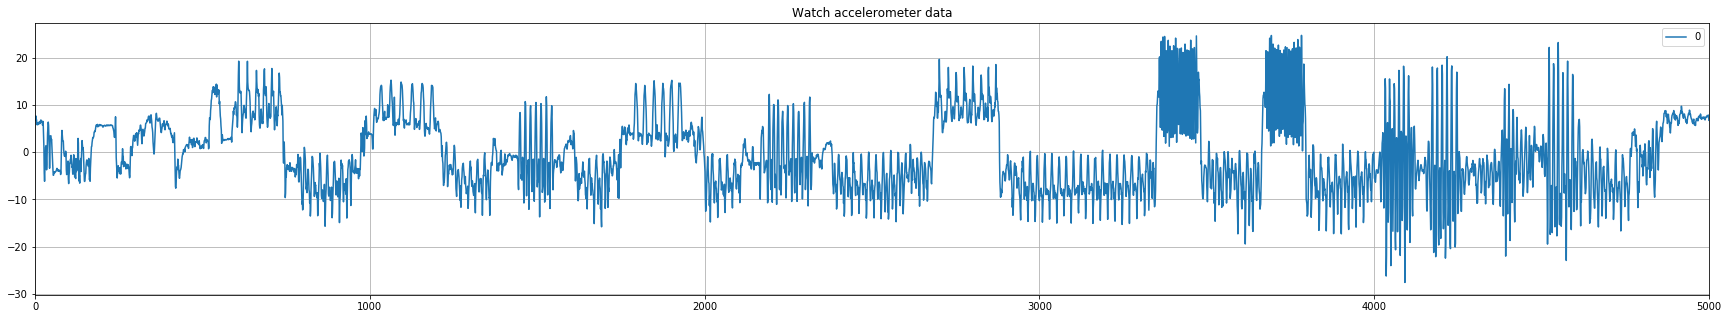

In [334]:
acc.plot(figsize = (30,5),title="Watch accelerometer data",grid=1,xlim=[0,len(acc)])

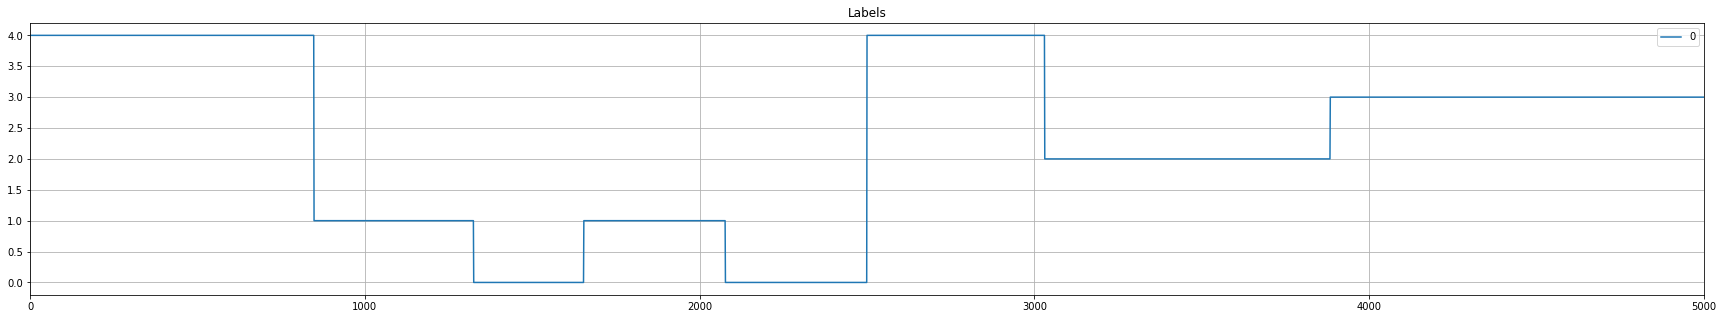

In [335]:
labels.plot(figsize = (30,5),title="Labels",grid=1,xlim=[0,len(labels)])

In [336]:
place_cluster = labels

In [337]:
place_cluster = place_cluster.values.reshape(-1).tolist()
places = set(place_cluster)

place = []
for p in places:
    loc = []
    for c in place_cluster:
        if p == c:
            loc.append(1)
        else:
            loc.append(0)
    place.append(loc)
            

In [338]:
places

{0, 1, 2, 3, 4}

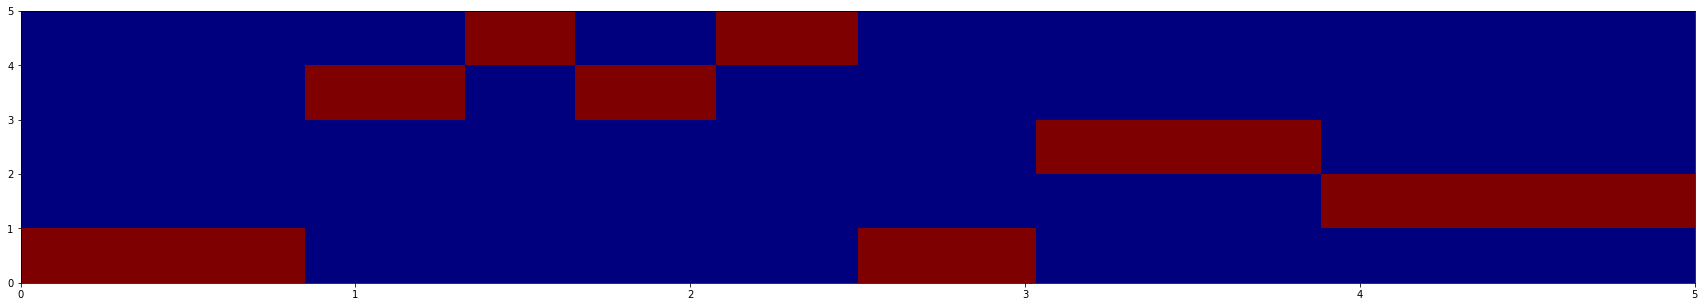

In [339]:
plt.figure(figsize=(30,5))
plt.imshow(place,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(places),0,len(place)], aspect='auto')

# Acceleration distance matrix calculation

In [13]:
window_len = 100
from sklearn import preprocessing
#Euclidian distance (edges have to be filled with zeros)
window_len = window_len
dist_mat = []
#std = []
y_window = []

acc_max = acc.max()
acc_min = acc.min()

for z in tqdm(range(0,len(acc)-window_len)):
    #std.append(acc[z:window_len+z].std())
    #avg.append(acc[z:window_len+z].mean())
    y_window.append((acc[z:window_len+z] - acc[z:window_len+z].mean() )/acc[z:window_len+z].std())


for y in tqdm(range(0,len(acc)-window_len)):
    feature = []
    #feature.extend(np.zeros(window_len/2))
    feature.extend(np.full((1, (window_len/2)), acc_max-acc_min).tolist()[0])
    #y_window = (acc[y:window_len+y] - avg[y])/std[y]
    for x in range(0,len(acc)-window_len):
        feature.append(distance.euclidean(y_window[y],y_window[x]))

    feature.extend(np.full((1, (window_len/2)), acc_max-acc_min).tolist()[0])
        
    dist_mat.append(feature)

100%|██████████| 4901/4901 [24:39<00:00,  3.42it/s]


In [14]:
acc_dist_mat = []
for n in range(0,window_len/2):
    #acc_dist_mat.append(np.zeros(len(np.array(dist_mat).T)).tolist())
    acc_dist_mat.append(np.full((1, len(np.array(dist_mat).T)), acc_max-acc_min).tolist()[0])
    
for line in dist_mat:
    acc_dist_mat.append(line)

for n in range(0,window_len/2):
    #acc_dist_mat.append(np.zeros(len(np.array(dist_mat).T)).tolist())
    acc_dist_mat.append(np.full((1, len(np.array(dist_mat).T)), acc_max-acc_min).tolist()[0])

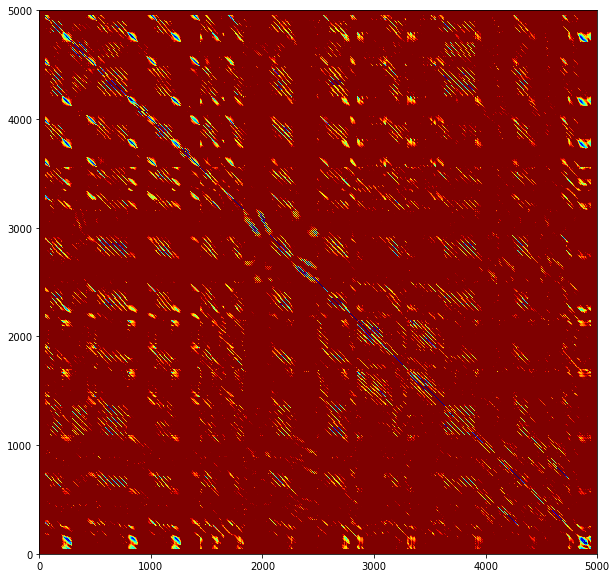

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(acc_dist_mat, cmap='jet', vmax=12, vmin=5, interpolation='nearest', origin='upper', extent=[0,len(acc_dist_mat),0,len(acc_dist_mat)], aspect='auto')
#plt.colorbar()

In [19]:
train_root

'env/5/dat/train_dat/'

In [20]:
pd.DataFrame(acc_dist_mat).to_csv(train_root + "acc_dist_mat", header=False, index=False)

## Acceleration similarity matrix calculation

In [21]:
max_dist = np.array(acc_dist_mat).max()
similarity_matrix = []
for feature in acc_dist_mat:
    sim = []
    for element in feature:
        simv=1.0-element/max_dist
        sim.append(simv if simv>0.8 else 0.0)
    similarity_matrix.append(sim)

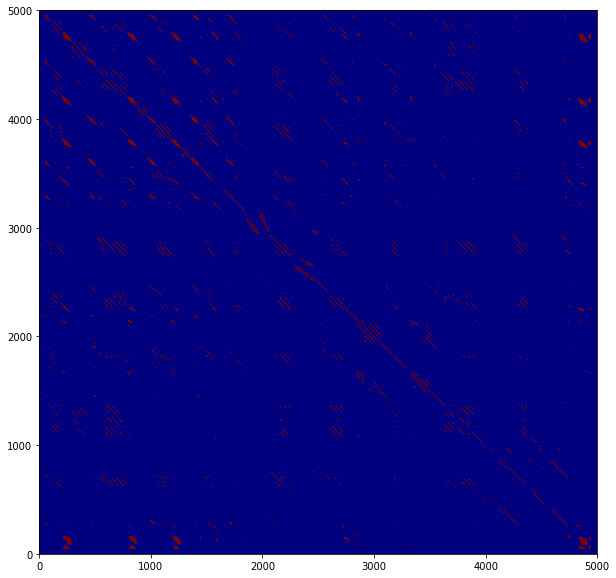

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(similarity_matrix, cmap='jet', vmax=0.8, interpolation='nearest', origin='upper', extent=[0,len(similarity_matrix),0,len(similarity_matrix)], aspect='auto')
#plt.colorbar()

# Calculating Similarity Coefficient

In [23]:
prob = []
num = 0
for items in np.array(similarity_matrix):
    p = []
    denom_array = []
    for m in range(0,len(places)):
        denom_array.append(np.multiply(place[m],items)/np.sum(place[m]))
        denom = np.sum(denom_array)
    for n in range(0,len(places)):
        if np.sum(np.multiply(items,np.asarray(place))) == 0.0:
            p.append(1.0/len(places))
            #print np.sum([np.multiply(items,place[0]) , np.multiply(items,place[1]) , np.multiply(items,place[2])])
        else:
            p.append((np.sum(np.multiply(place[n],items))/np.sum(place[n])) / denom)#np.sum([np.multiply(items,place[0])/np.sum(place[0]) , np.multiply(items,place[1])/np.sum(place[1]) , np.multiply(items,place[2])/np.sum(place[2])]))#/np.sum([np.multiply(items,place[0]) , np.multiply(items,place[1]) , np.multiply(items,place[2])])
    prob.append(p)

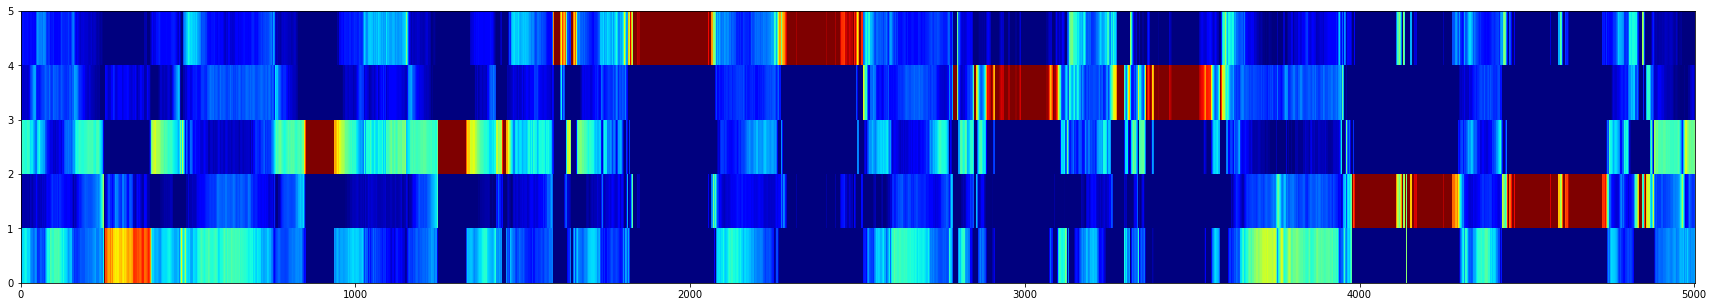

In [24]:
plt.figure(figsize=(30,5))
plt.imshow(np.array(prob)[50:len(similarity_matrix)-50].T,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(prob),0,len(place)], aspect='auto')
#plt.colorbar()

In [25]:
pd.DataFrame(prob).T.to_csv(train_root + "env_mot_probs", header=False, index=False)

In [26]:
prob_sum = []
for probs in prob:
    prob_sum.append(np.sum(np.power(probs,2)))

gini = []
for items in prob_sum:
    gini.append(1-items)

In [27]:
pd.DataFrame(prob_sum).to_csv(train_root + "sim_coefs", header=False, index=False)

In [340]:
prob_sum = pd.read_csv(train_root + "sim_coefs")
prob_sum = prob_sum.values

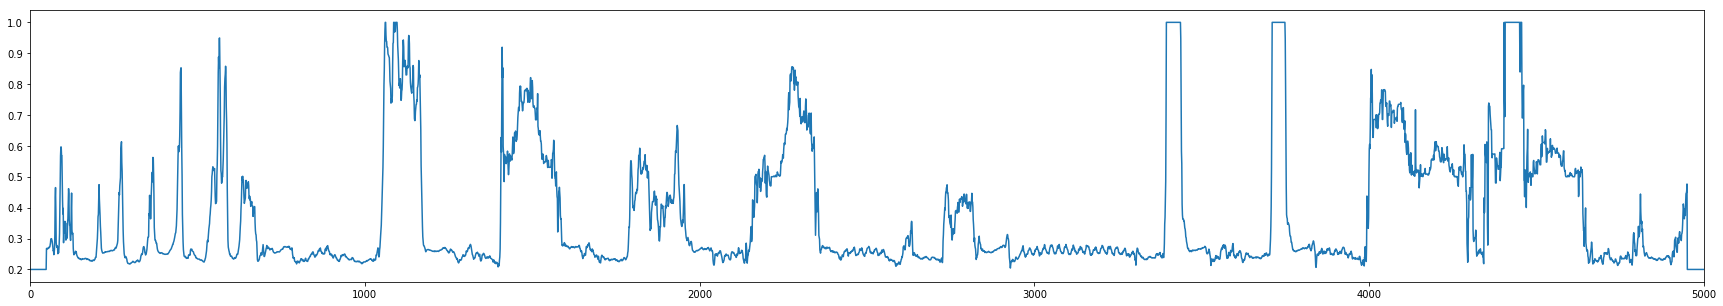

In [341]:
plt.figure(figsize=(30,5))
plt.xlim(0,len(prob_sum))
plt.plot(prob_sum)

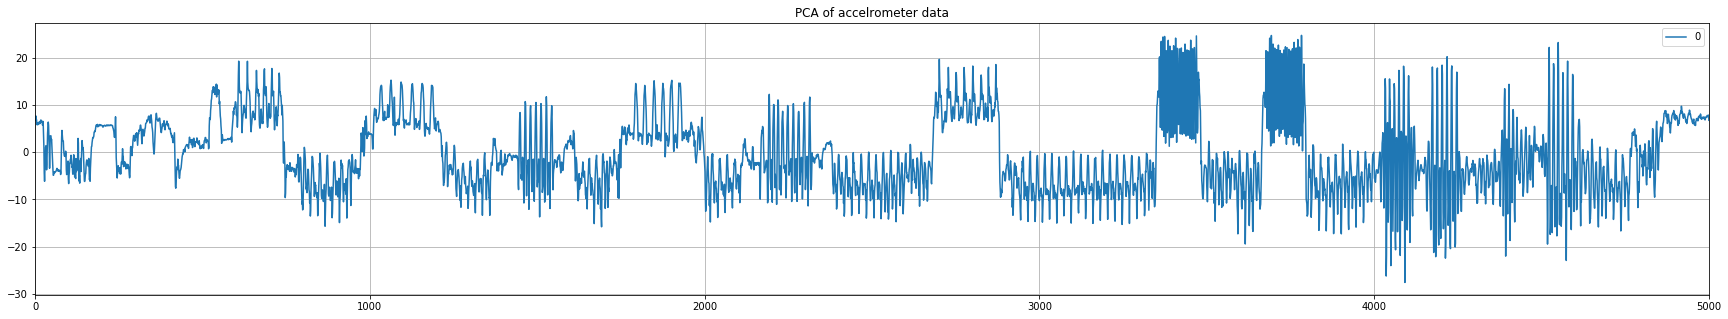

In [342]:
acc.plot(figsize = (30,5),title="PCA of accelrometer data",grid=1,xlim=[0,len(acc)])

all_motif_locations = []
left = 0
right = 0 
mid = 0
for sample in range(0,len(prob_sum)):
    itr = []
    left = sample
    right = sample+1
    if prob_sum[left]>=0.8:
        while right<len(prob_sum) and prob_sum[right]>=0.8:
            right = right+1
        mid = int((left+right)/2.0)
        print left,right
    left = right    
        
    
        all_motif_locations.append(mid)    

## Consider adjacent values that are greater than 0.8 as a set (for MR extraction)

In [343]:
all_motif_locations = []
left = 0
right = 0 
mid = 0
while left<len(prob_sum):
    right = left+1
    if prob_sum[left]>=0.8:
        while right<len(prob_sum) and prob_sum[right]>=0.8:
            right = right+1
        mid = int((left+right)/2.0)
        all_motif_locations.append(mid) 
        print left,right
        left = right    
    left = left+1    
    
           

449 452
562 568
582 586
1058 1076
1083 1102
1103 1104
1106 1107
1112 1137
1143 1146
1159 1165
1410 1413
1494 1496
1500 1501
2270 2283
2285 2289
2293 2294
3394 3438
3710 3751
4006 4007
4008 4009
4403 4404
4406 4456


all_motif_locations = []
left = 0
right = 0 
for sample in range(0,len(prob_sum)):
    itr = []
    if prob_sum[sample]>=0.8:
        all_motif_locations.append(sample)    

In [344]:
pd.DataFrame(all_motif_locations)

,0
0,450
1,565
2,584
3,1067
4,1092
5,1103
6,1106
7,1124
8,1144
9,1162


In [345]:
all_mots = []
locs = []
mot_labels = []

for m_loc in all_motif_locations:
    if m_loc>=window_len/2 and m_loc<len(acc)-window_len/2:
        locs.append(m_loc)
        mot_labels.append(labels.values[m_loc])
        all_mots.append(acc.values[m_loc-window_len/2:m_loc+window_len/2])

In [346]:
len(all_mots)

22

In [347]:
all_mots = np.array(all_mots).reshape(len(all_mots),window_len)

In [348]:
all_mots = pd.DataFrame(all_mots)
mot_labels = pd.DataFrame(mot_labels,columns=["label"])

In [349]:
all_mots = pd.concat([mot_labels,all_mots],axis = 1,sort=False)

In [350]:
pd.DataFrame(all_mots).to_csv(train_root + "all_mots", header=False, index=False)

# Motif extraction (for feature extraction)

In [351]:
all_motif_locations2 = []
for sample in range(0,len(prob_sum)):
    itr = []
    if prob_sum[sample]>=0.8:
        all_motif_locations2.append(sample)    

In [352]:
all_motif_locations2

[449,
 450,
 451,
 562,
 563,
 564,
 565,
 566,
 567,
 582,
 583,
 584,
 585,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1083,
 1084,
 1085,
 1086,
 1087,
 1088,
 1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1103,
 1106,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1143,
 1144,
 1145,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1410,
 1411,
 1412,
 1494,
 1495,
 1500,
 2270,
 2271,
 2272,
 2273,
 2274,
 2275,
 2276,
 2277,
 2278,
 2279,
 2280,
 2281,
 2282,
 2285,
 2286,
 2287,
 2288,
 2293,
 3394,
 3395,
 3396,
 3397,
 3398,
 3399,
 3400,
 3401,
 3402,
 3403,
 3404,
 3405,
 3406,
 3407,
 3408,
 3409,
 3410,
 3411,
 3412,
 3413,
 3414,
 3415,
 3416,
 3417,
 3418,
 3419,
 3420,
 3421,
 3422,
 3423,
 3424,
 3425,
 3426,
 3427,
 3428

In [353]:
all_mots2 = []
locs2 = []
mot_labels2 = []

for m_loc in all_motif_locations2:
    if m_loc>=window_len/2 and m_loc<len(acc)-window_len/2:
        locs.append(m_loc)
        mot_labels2.append(labels.values[m_loc])
        all_mots2.append(acc.values[m_loc-window_len/2:m_loc+window_len/2])

In [354]:
print len(all_mots2)

all_mots2 = np.array(all_mots2).reshape(len(all_mots2),window_len)

all_mots2 = pd.DataFrame(all_mots2)
mot_labels2 = pd.DataFrame(mot_labels2,columns=["label"])

all_mots2 = pd.concat([mot_labels2,all_mots2],axis = 1,sort=False)

248


In [355]:
all_mots2

,label,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,4,5.066075,4.884479,4.979053,4.945480,5.054373,4.562287,3.927812,3.985675,3.437405,...,1.579680,2.421735,1.568714,1.478415,0.736521,1.203954,0.951443,1.136800,0.836175,1.342993
1,4,4.884479,4.979053,4.945480,5.054373,4.562287,3.927812,3.985675,3.437405,3.220083,...,2.421735,1.568714,1.478415,0.736521,1.203954,0.951443,1.136800,0.836175,1.342993,1.144806
2,4,4.979053,4.945480,5.054373,4.562287,3.927812,3.985675,3.437405,3.220083,3.591258,...,1.568714,1.478415,0.736521,1.203954,0.951443,1.136800,0.836175,1.342993,1.144806,1.605457
3,4,2.379443,2.650247,2.572430,2.323800,2.265424,2.187688,0.725958,1.105004,5.561058,...,7.943226,7.263706,5.300312,6.954078,12.057708,16.329303,19.274026,16.231391,13.790479,12.691509
4,4,2.650247,2.572430,2.323800,2.265424,2.187688,0.725958,1.105004,5.561058,7.294464,...,7.263706,5.300312,6.954078,12.057708,16.329303,19.274026,16.231391,13.790479,12.691509,12.614196
5,4,2.572430,2.323800,2.265424,2.187688,0.725958,1.105004,5.561058,7.294464,6.879169,...,5.300312,6.954078,12.057708,16.329303,19.274026,16.231391,13.790479,12.691509,12.614196,12.470149
6,4,2.323800,2.265424,2.187688,0.725958,1.105004,5.561058,7.294464,6.879169,7.051170,...,6.954078,12.057708,16.329303,19.274026,16.231391,13.790479,12.691509,12.614196,12.470149,12.904115
7,4,2.265424,2.187688,0.725958,1.105004,5.561058,7.294464,6.879169,7.051170,8.858572,...,12.057708,16.329303,19.274026,16.231391,13.790479,12.691509,12.614196,12.470149,12.904115,12.345238
8,4,2.187688,0.725958,1.105004,5.561058,7.294464,6.879169,7.051170,8.858572,9.581891,...,16.329303,19.274026,16.231391,13.790479,12.691509,12.614196,12.470149,12.904115,12.345238,9.646870
9,4,13.861681,13.111192,13.279831,13.370795,13.615119,12.219650,13.845287,12.822757,13.206664,...,8.333086,9.826997,9.914905,9.574146,8.460507,9.064006,8.174708,7.317614,7.199287,10.962444


In [356]:
train_root

'env/10/dat/train_dat/'

In [357]:
pd.DataFrame(all_mots2).to_csv(train_root + "all_mots2", header=False, index=False)